# Lib

In [92]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold
import matplotlib.pyplot as plt
import pandas_profiling

# Reading CSV Files

In [93]:
training = pd.read_csv('tcd-ml-1920-group-income-train.csv')
testing = pd.read_csv('tcd-ml-1920-group-income-test.csv')    

U:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
U:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Filling N/A


In [7]:
training[training.columns]=training[training.columns].fillna(training.mode().iloc[0])
testing[testing.columns]=testing[testing.columns].fillna(testing.mode().iloc[0])

# Data Analysis (by each column)

In [8]:
training['Gender'].value_counts()

male       474240
other      252053
female     237489
unknown     62957
f           15031
0            6804
Name: Gender, dtype: int64

In [9]:
training["Gender"] = training["Gender"].replace('f','female')
training["Gender"] = training["Gender"].replace('0','unknown')

In [10]:
testing["Gender"] = testing["Gender"].replace('f','female')
testing["Gender"] = testing["Gender"].replace('0','unknown')

In [11]:
training['Housing Situation'] = training['Housing Situation'].astype(str)

In [12]:
a = training['Housing Situation'].mode()[0]

In [13]:
training['Housing Situation'].replace('nA',a, inplace=True)

In [14]:
testing['Housing Situation'] = testing['Housing Situation'].astype(str)

In [15]:
a = testing['Housing Situation'].mode()[0]

In [16]:
testing['Housing Situation'].replace('nA',a, inplace=True)

In [17]:
training['University Degree'].replace('0',training['University Degree'].mode()[0], inplace=True)
testing['University Degree'].replace('0',testing['University Degree'].mode()[0], inplace=True)

In [18]:
training['Yearly Income in addition to Salary (e.g. Rental Income)'] = training['Yearly Income in addition to Salary (e.g. Rental Income)'].str.replace('([A-Za-z]+)', '')
training['Yearly Income in addition to Salary (e.g. Rental Income)'] = pd.to_numeric(training['Yearly Income in addition to Salary (e.g. Rental Income)'],errors='coerce')
testing['Yearly Income in addition to Salary (e.g. Rental Income)'] = testing['Yearly Income in addition to Salary (e.g. Rental Income)'].str.replace('([A-Za-z]+)', '')
testing['Yearly Income in addition to Salary (e.g. Rental Income)'] = pd.to_numeric(testing['Yearly Income in addition to Salary (e.g. Rental Income)'],errors='coerce')

In [19]:
training['Work Experience in Current Job [years]'].replace('#NUM!',training['Work Experience in Current Job [years]'].mode()[0], inplace=True)
testing['Work Experience in Current Job [years]'].replace('#NUM!',testing['Work Experience in Current Job [years]'].mode()[0], inplace=True)

In [20]:
training['Work Experience in Current Job [years]'] = pd.to_numeric(training['Work Experience in Current Job [years]'],errors='coerce')

In [21]:
testing['Work Experience in Current Job [years]'] = pd.to_numeric(testing['Work Experience in Current Job [years]'],errors='coerce')

In [22]:
training[training.columns]=training[training.columns].fillna(training.mode().iloc[0])
testing[testing.columns]=testing[testing.columns].fillna(testing.mode().iloc[0])

In [24]:
training['flag'] = 1
testing['flag'] = 0

# Concatinating Train and Testing

In [25]:
data = pd.concat([training, testing], ignore_index=True)

# Checking Data Types

In [27]:
data.dtypes

Instance                                                      int64
Year of Record                                              float64
Housing Situation                                            object
Crime Level in the City of Employement                        int64
Work Experience in Current Job [years]                      float64
Satisfation with employer                                    object
Gender                                                       object
Age                                                           int64
Country                                                      object
Size of City                                                  int64
Profession                                                   object
University Degree                                            object
Wears Glasses                                                 int64
Hair Color                                                   object
Body Height [cm]                                

# Drop unnecessary column

In [28]:
training.drop(columns=['Hair Color'], inplace=True)

In [29]:
testing.drop(columns=['Hair Color'], inplace=True)

# Applying Encoders

## Label Encoder

In [30]:
for i in data.dtypes[data.dtypes == 'object'].index.tolist():
    print(i)
    featureLE = LabelEncoder()
    featureLE.fit(data[i].unique().astype(str))
    data[i] = featureLE.transform(data[i].astype(str))

Housing Situation
Satisfation with employer
Gender
Country
Profession
University Degree
Hair Color


## Target Encoder

In [133]:
for i in data.dtypes[data.dtypes == 'object'].index.tolist():
    print(i)
    grp_hs = data.groupby(i)["Total Yearly Income [EUR]"].agg("mean")
    data[i] = data[i].map(grp_hs) 

Housing Situation
Satisfation with employer
Gender
Country
Profession
University Degree
Hair Color


# Displaying the Data

In [32]:
data.drop(columns=['Hair Color'], inplace=True)

In [33]:
data.drop(columns=['Instance'], inplace=True)

In [76]:
data.head()

,Year of Record,Housing Situation,Crime Level in the City of Employement,Work Experience in Current Job [years],Satisfation with employer,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Body Height [cm],Yearly Income in addition to Salary (e.g. Rental Income),Total Yearly Income [EUR],flag
0,1940.0,0,33,17.0,3,2,45,1,25179,610,2,1,182,0.0,6182.05,1
1,1940.0,0,25,4.9,3,0,17,1,2278204,622,2,0,172,0.0,6819.69,1
2,1940.0,0,34,21.0,3,0,48,1,822134,1193,0,0,144,0.0,8663.53,1
3,1940.0,0,70,18.0,0,0,42,2,59477,1007,2,1,152,0.0,2400.64,1
4,1940.0,0,51,8.0,1,2,15,2,23494,760,1,1,180,0.0,2816.18,1


# Dividing the Training and Testing data

In [88]:
XTrain = data[data['flag'] == 1]
XTest = data[data['flag'] == 0]

In [89]:
XTrain_final = XTrain.drop(columns=['flag','Total Yearly Income [EUR]'])
XTest_final = XTest.drop(columns=['flag','Total Yearly Income [EUR]'])

In [90]:
YTrain_final = XTrain['Total Yearly Income [EUR]']

In [91]:
xTrain,xValidation,yTrain,yValidation = train_test_split(XTrain_final,YTrain_final,test_size=0.2,random_state=341)    

# Applying LightGBM

In [82]:
d_train = lgb.Dataset(xTrain, label=yTrain)

In [83]:
params = {'max_depth': 20, 'learning_rate': 0.04, "boosting": "gbdt", "bagging_seed": 11, "metric": 'mae', "verbosity": -1, 'categorical_features':'auto'}

In [61]:
lab_enc = preprocessing.LabelEncoder()
yTrain_ = lab_enc.fit_transform(yTrain)
yValidation_ = lab_enc.fit_transform(yValidation)

In [84]:
clf = lgb.train(params, d_train, 30000)

In [85]:
y_predicted = clf.predict(xValidation)

In [86]:
mean_absolute_error(yValidation, y_predicted)

17372.805312944267

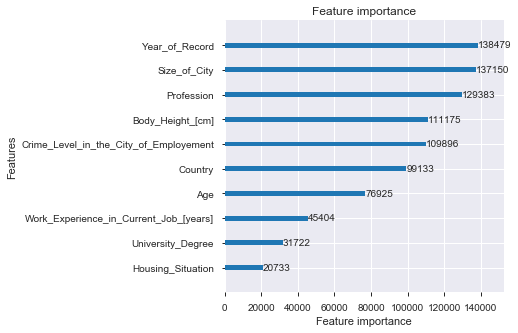

In [87]:
lgb.plot_importance(clf)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

# Predicting on Test Data and Saving Files

In [75]:
y_predicted = clf.predict(XTest_final)

sub = pd.read_csv('tcd-ml-1920-group-income-submission.csv')

sub['Total Yearly Income [EUR]'] = y_predicted

sub.to_csv('_ML2.csv',index=False)